<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/ArchitectureGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU



Epoch 0: Loss 0.5772981687719331
Epoch 10: Loss 0.5504607254614231
Epoch 20: Loss 0.5211269608315052
Epoch 30: Loss 0.4891154689963624
Epoch 40: Loss 0.454172518439333
Epoch 50: Loss 0.41622967818887174
Epoch 60: Loss 0.3755194049701644
Epoch 70: Loss 0.33550749927827117
Epoch 80: Loss 0.2942912830479593
Epoch 90: Loss 0.2532028341542168
Epoch 100: Loss 0.21231984247826707
Epoch 110: Loss 0.17482926230314977
Epoch 120: Loss 0.14091184211333024
Epoch 130: Loss 0.11268459148844519
Epoch 140: Loss 0.0867640179981183
Epoch 150: Loss 0.0684193672136083
Epoch 160: Loss 0.05065086185625717
Epoch 170: Loss 0.0374845035244595
Epoch 180: Loss 0.026616609874078802
Epoch 190: Loss 0.020937113904452742
Epoch 200: Loss 0.01448322557774218
Epoch 210: Loss 0.010590451573140387
Epoch 220: Loss 0.007934452128400419
Epoch 230: Loss 0.00731564202509604
Epoch 240: Loss 0.004342126981796752
Epoch 250: Loss 0.003653651015984265
Epoch 260: Loss 0.004151117785594408
Epoch 270: Loss 0.0023198464359633626
Epoch

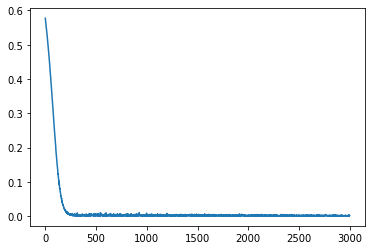

In [2]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import regenerate_PWMatrix
from scipy.stats import wasserstein_distance as WD

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        typed_trimmed_specs.append(specs[i])

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                ar[i][j] = r
                ar[j][i] = 1-r

    return ar

def generate_train_set(n):
    train_x = []
    full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
    train_y = get_LT(full_m.to_numpy())

    pbar2=tqdm(range(n))
    pbar2.set_description('Generating Train Data')
    for epoch in pbar2:

        npcm = np.zeros(len(trimmed_specs))
        size = rd.randint(25, 235)
        subset = rd.sample(trimmed_specs, size)
        subset_lam = (full_m.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)

        for i in subset:
            npcm[trimmed_specs.index(i)] = 0
        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]
        train_x.append(npcm)

    return train_x, train_y

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_net(model, train_size):
    loss_values = []
    pbar2=tqdm(range(train_size))
    pbar2.set_description('Training Neural Net')
    train_x, train_y = generate_train_set(n=train_size)

    for i in pbar2:
        optimizer.zero_grad()
        x, y = train_x[i], train_y
        input = torch.from_numpy(x).float().to(device)
        true_y = torch.FloatTensor(y).to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = sqrt(loss.item()/(231*461))
        if (i % 10)==0:
          print(f'Epoch {i}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()
    return loss_values, train_y

def test_net(model, Lambda_Mat):
    full_cm = predict_community_fullnp(Lambda_Mat, trimmed_specs)
    input = torch.from_numpy(full_cm).float().to(device)
    Lambda_Mat_pred = model(input).to(device)

    true_y = torch.FloatTensor(np.array(get_LT(Lambda_Mat))).to(device)

    loss1 = criterion(Lambda_Mat_pred, true_y).to(device)
    s = sqrt(loss1.item()/(231*461))
    LMP_list = Lambda_Mat_pred.tolist()
    lam2 = np.array(regenerate_PWMatrix(LMP_list, 462))
    cm_pred = predict_community_fullnp(lam2, trimmed_specs)
    loss2 = WD(full_cm, cm_pred)
    print(s)
    print(loss2)
    print([x.round(4) for x in full_cm])
    print([x.round(4) for x in cm_pred])

if __name__=='__main__':
    train_size, test_size, param = 3000, 25, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    lv, full_lam = train_net(net, train_size=train_size)
    full_lam = np.array(regenerate_PWMatrix(full_lam, 462))
    test_net(net, full_lam)
    torch.save(net.state_dict(), path)
    plt.plot(lv)
    plt.savefig('Loss')
    plt.show()
